<p align="center">
  <img width="100" height="100" src="../images/logo.png">
</p>

<div>
<h1>03. Preproceso: Modelo C_SEV</h1> 

Canadian Car Accidents Practice <br>
<strong>Aprendizaje Automático</strong> <br>
<strong>Master Universitario en Ciencia de Datos</strong>
</div>

<div style='text-align:right'>Álvaro Serrano del Rincón (<i>a.serranodelrincon@cunef.edu</i>)</div>
<div style='text-align:right'>Carlos Viñals Guitart (<i>carlos.vinals@cunef.edu</i>)</div>

---

## 3.0 Introducción

En este notebook realizaremos el preprocesado de los datos del dataset conforme al análisis realizado en el notebook EDA 
```01_EDA```. Para ello procederemos a explicar paso a paso las decisiones tomadas en cuanto a su preprocesado.

Para este trabajo estamos utilizando un entorno de propósito espécifico.

In [1]:
# Verificamos el entorno: ML_P1
!conda info


     active environment : ML_P1
    active env location : C:\Users\carviagu\anaconda3\envs\ML_P1
            shell level : 2
       user config file : C:\Users\carviagu\.condarc
 populated config files : 
          conda version : 4.10.3
    conda-build version : 3.21.4
         python version : 3.8.8.final.0
       virtual packages : __cuda=11.3=0
                          __win=0=0
                          __archspec=1=x86_64
       base environment : C:\Users\carviagu\anaconda3  (writable)
      conda av data dir : C:\Users\carviagu\anaconda3\etc\conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/win-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/win-64
                          https://repo.anaconda.com/pkgs/r/noarch
                          https://repo.anaconda.com/pkgs/msys2/win-64
                          https://repo.anaconda.com/pkgs/msys2/no

### 3.0.1 Estructura

0. Librerías y Scripts
1. Lectura y preparación
2. Train y Test
3. Tratamiento
    - Valores faltantes
    - Codificación
4. Balanceo de Train
5. Selección de variables
    - Correlaciones
    - Regresión de Lasso
6. Guardado


## Librerías

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
import matplotlib
import nbconvert

%matplotlib inline

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.linear_model import ElasticNet

from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

## Scripts
En este notebook procedemos a importar dos scripts con funciones útiles, previamente utilizadas en el EDA y que permitirán verificar el proceso de realización de las muestras de train y test.

In [3]:
import sys

import sys  
sys.path.insert(0, '../scripts/')

import csv_tools
import eda_tools

## 3.1 Lectura y preparación

A continuación leeremos el dataset, de la misma forma que lo hicimos en el EDA.

In [4]:
# Función propia que verifica que existe el fichero de datos previamente.
accidents_df = csv_tools.csv_import(origin="../data/sev_df.csv")

Reading file...
Reading ended.


In [5]:
accidents_df.head()

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,C_PERS
0,1999,oto/inv,week,night,2,01,one vehicle,normal,normal,dragged,normal,unsafe,1
1,1999,oto/inv,week,night,2,01,one vehicle,normal,normal,dragged,normal,unsafe,1
2,1999,oto/inv,week,night,2,01,one vehicle,normal,bad,normal,normal,unsafe,1
3,1999,oto/inv,week,night,2,01,one vehicle,normal,bad,dragged,curve/ramp,unsafe,2
4,1999,oto/inv,week,night,2,01,one vehicle,UU,normal,normal,curve/ramp,unsafe,1


## 3.2 Train y Test
A continuación vamos a proceder a crear y dividir los datos en Train (muestra de entrenamiento) y test (muestra de test) que usaremos para nuestros modelos. 

In [6]:
# Separamos los valores (X) de la variable objetivo (Y)
X = accidents_df.drop('C_SEV', axis=1)
Y = accidents_df['C_SEV']

# Realizamos la división de train y test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=1234, stratify=Y)

## 3.3 Tratamiento
A continuación procederemos a realizar la limpieza de los datos y su procesamiento:

Analizamos tipos:

In [7]:
eda_tools.dataset_overview(data = X_train)

,columna,tipo_dato,nulos,nulos%
0,C_YEAR,int64,0,0.0
1,C_MNTH,object,0,0.0
2,C_WDAY,object,0,0.0
3,C_HOUR,object,0,0.0
4,C_VEHS,object,0,0.0
5,C_CONF,object,0,0.0
6,C_RCFG,object,0,0.0
7,C_WTHR,object,0,0.0
8,C_RSUR,object,0,0.0
9,C_RALN,object,0,0.0


### 3.3.2 Valores faltantes
Para llevar a cabo este proceso realizaremos la conversión correspondiente por tipo de variable, esto es, pues el signficado que estas tienen es distinto. 

A nivel general si el porcentaje es inferior a 0.1 dedicidimos eliminar esas variables, en caso contrario aplicaremos una técnicas de sustitución de ese valor. Consideramos que un valor inferior a 0.1 no es relevante para los datos.

Primero veamos como está la muestra de train:

In [8]:
especial_values = [['U', 'UU', 'UUUU'], ['Q', 'QQ', 'QQQQ']]

# Valoración del train
eda_tools.special_values_summary(df = X_train, vals = especial_values)

C:\Users\carviagu\anaconda3\envs\ML_P1\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,column_name,U,U%,Q,Q%,total,total%
0,C_YEAR,0,[0.0],0,[0.0],0,0.0
1,C_MNTH,70,[0.005],0,[0.0],70,0.0
2,C_WDAY,396,[0.028],0,[0.0],396,0.0
3,C_HOUR,18527,[1.293],0,[0.0],18527,1.3
4,C_VEHS,115,[0.008],0,[0.0],115,0.0
5,C_CONF,52301,[3.65],84865,[5.923],137166,9.6
6,C_RCFG,141564,[9.88],48341,[3.374],189905,13.3
7,C_WTHR,26611,[1.857],4228,[0.295],30839,2.2
8,C_RSUR,23205,[1.62],50952,[3.556],74157,5.2
9,C_RALN,116756,[8.149],8519,[0.595],125275,8.7


In [9]:
# Valoración del test
eda_tools.special_values_summary(df = X_test, vals = especial_values)

,column_name,U,U%,Q,Q%,total,total%
0,C_YEAR,0,[0.0],0,[0.0],0,0.0
1,C_MNTH,24,[0.007],0,[0.0],24,0.0
2,C_WDAY,96,[0.027],0,[0.0],96,0.0
3,C_HOUR,4540,[1.267],0,[0.0],4540,1.3
4,C_VEHS,24,[0.007],0,[0.0],24,0.0
5,C_CONF,13009,[3.632],21035,[5.872],34044,9.5
6,C_RCFG,35766,[9.985],11890,[3.319],47656,13.3
7,C_WTHR,6782,[1.893],1099,[0.307],7881,2.2
8,C_RSUR,5849,[1.633],12546,[3.502],18395,5.1
9,C_RALN,29573,[8.256],2208,[0.616],31781,8.9


Generalmente analizaremos primero el porcentaje de valores especiales, siendo igual o inferior a 0.1% el criterio de eliminación de estos del dataset. En el resto se analizará la variable objetivo mayoritaria y se buscará el valor más frecuente con la misma variable objetivo para realizar la clasificación. En el caso de las variables ```Q``` se seguirá el mismo criterio si bien en algunos casos por razones de que no se tratan de simples datos faltantes deberán categorizarse de manera específica.
Lo analizamos a continuación:

```C_MNTH```: Observamos valores ```U```, estos son inferiores a un 0.1% lo que los hace insignificantes dentro y por lo tanto los eliminamos.

In [10]:
# Train
to_drop = X_train[X_train['C_MNTH'] == 'UU'].index
X_train = X_train.drop(to_drop, axis=0)
Y_train = Y_train.drop(to_drop, axis=0)

# Test
to_drop = X_test[X_test['C_MNTH'] == 'UU'].index
X_test = X_test.drop(to_drop, axis=0)
Y_test = Y_test.drop(to_drop, axis=0)

```C_WDAY```: Observamos valores ```U```, estos son inferiores a un 0.1% lo que los hace insignificantes dentro y por lo tanto los eliminamos.

In [11]:
# Train
to_drop = X_train[X_train['C_WDAY'] == 'U'].index
X_train = X_train.drop(to_drop, axis=0)
Y_train = Y_train.drop(to_drop, axis=0)

# Test
to_drop = X_test[X_test['C_WDAY'] == 'U'].index
X_test = X_test.drop(to_drop, axis=0)
Y_test = Y_test.drop(to_drop, axis=0)

```C_HOUR```: Observamos que hay valores ```U```. Hacemos uso de una tabla resumen que muestra el porcentaje de valores por categoría y la variable objetivo mayoritaria de esa categoría.

In [12]:
XY_train = X_train.copy()
XY_train['C_SEV'] = Y_train
eda_tools.classes_overview_target(df = XY_train, target = 'C_SEV', obj_val = 'C_HOUR')

,index,percentaje,C_HOUR,C_SEV
0,afternoon,39.298215,562921,2
1,morning,35.191639,504097,2
2,night,24.225060,347008,1
3,UU,1.285085,18408,1


Categorizaremos los valores ```UU``` como accidentes nocturnos (```night```), pues es la variable mayoritaria con su misma variable objetivo.

In [13]:
X_train['C_HOUR'] = X_train['C_HOUR'].replace(to_replace = 'UU', value = 'night')
X_test['C_HOUR'] = X_test['C_HOUR'].replace(to_replace = 'UU', value = 'night')

```C_VEHS```: Observamos valores ```U```, estos son inferiores a un 0.1% lo que los hace insignificantes dentro y por lo tanto los eliminamos.

In [14]:
# Train
to_drop = X_train[X_train['C_VEHS'] == 'UU'].index
X_train = X_train.drop(to_drop, axis=0)
Y_train = Y_train.drop(to_drop, axis=0)

# Test
to_drop = X_test[X_test['C_VEHS'] == 'UU'].index
X_test = X_test.drop(to_drop, axis=0)
Y_test = Y_test.drop(to_drop, axis=0)

```C_CONF```: Tiene valores ```U``` y ```Q```. Ambos valores presentan la misma variable objetivo mayoritaria respecto a una de las clases, por lo que las clasificaremos como ```one vehicle```.

In [15]:
XY_train = X_train.copy()
XY_train['C_SEV'] = Y_train
eda_tools.classes_overview_target(df = XY_train, target = 'C_SEV', obj_val = 'C_CONF')

,index,percentaje,C_CONF,C_SEV
0,two opp dir,31.649601,453328,1
1,one vehicle,30.957933,443421,2
2,two same dir,27.822002,398504,1
3,QQ,5.921594,84817,2
4,UU,3.648870,52264,2


In [16]:
# Valores QQ se engloban dentro de la categoría other
X_train['C_CONF'] = X_train['C_CONF'].replace(to_replace = 'QQ', value = 'one vehicle')
X_test['C_CONF'] = X_test['C_CONF'].replace(to_replace = 'QQ', value = 'one vehicle')

# Valores UU se traspasan a la categoría de back
X_train['C_CONF'] = X_train['C_CONF'].replace(to_replace = 'UU', value = 'one vehicle')
X_test['C_CONF'] = X_test['C_CONF'].replace(to_replace = 'UU', value = 'one vehicle')

```C_RCFG```: Tiene valores ```U``` y ```Q```. Los valores ```Q``` por su naturaleza se asignan a la categoría ```specific```, los valores ```U``` se categorizarán como ```normal```, pues coincide en variable objetivo. 

In [17]:
XY_train = X_train.copy()
XY_train['C_SEV'] = Y_train
eda_tools.classes_overview_target(df = XY_train, target = 'C_SEV', obj_val = 'C_RCFG')

,index,percentaje,C_RCFG,C_SEV
0,specific,48.054364,688299,1
1,normal,38.698306,554289,2
2,UU,9.873535,141422,2
3,QQ,3.373794,48324,1


In [18]:
# Valores QQ se engloban dentro de la categoría specific, no pueden ser normales
X_train['C_RCFG'] = X_train['C_RCFG'].replace(to_replace = 'QQ', value = 'specific')
X_test['C_RCFG'] = X_test['C_RCFG'].replace(to_replace = 'QQ', value = 'specific')

# Valores UU se traspasan a la categoría de specific, misma C_SEV
X_train['C_RCFG'] = X_train['C_RCFG'].replace(to_replace = 'UU', value = 'normal')
X_test['C_RCFG'] = X_test['C_RCFG'].replace(to_replace = 'UU', value = 'normal')

```C_WTHR```: Tiene valores ```U``` y ```Q```. Los valores ```Q``` por su naturaleza se asignan a la categoría ```bad```, asumimos que son condiciones poco habituales. En el caso de los valores ```U``` se caracterizan como ```normal``` al coincidir su variabe objetivo.

In [19]:
XY_train = X_train.copy()
XY_train['C_SEV'] = Y_train
eda_tools.classes_overview_target(df = XY_train, target = 'C_SEV', obj_val = 'C_WTHR')

,index,percentaje,C_WTHR,C_SEV
0,normal,64.098318,918102,2
1,bad,33.751416,483433,1
2,U,1.855224,26573,2
3,Q,0.295043,4226,1


In [20]:
# Valores QQ se engloban dentro de la categoría bad, asumimos que son condiciones poco habituales
X_train['C_WTHR'] = X_train['C_WTHR'].replace(to_replace = 'Q', value = 'bad')
X_test['C_WTHR'] = X_test['C_WTHR'].replace(to_replace = 'Q', value = 'bad')

# Valores UU se traspasan a la categoría de normal, variable mayoritaria (sin coincidencias de CSEV)
X_train['C_WTHR'] = X_train['C_WTHR'].replace(to_replace = 'U', value = 'normal')
X_test['C_WTHR'] = X_test['C_WTHR'].replace(to_replace = 'U', value = 'normal')

```C_RSUR```: Tiene valores ```U``` y ```Q```. Los cuales cuales clasificaremos como carreteras con problemas (```dragged```). Pues ambas poseen una variable objetivo mayoritaria común y, además, las ```Q``` por su razón de ser otro tipo de situación de carretera no contemplada la debemos de clasificar en esta segunda categoría.

In [21]:
XY_train = X_train.copy()
XY_train['C_SEV'] = Y_train
eda_tools.classes_overview_target(df = XY_train, target = 'C_SEV', obj_val = 'C_RSUR')

,index,percentaje,C_RSUR,C_SEV
0,normal,79.432381,1137737,1
1,dragged,15.395082,220509,2
2,Q,3.555176,50922,2
3,U,1.617360,23166,2


In [22]:
# Valores Q se engloban dentro de la categoría dragged, no pueden ser normales
X_train['C_RSUR'] = X_train['C_RSUR'].replace(to_replace = 'Q', value = 'dragged')
X_test['C_RSUR'] = X_test['C_RSUR'].replace(to_replace = 'Q', value = 'dragged')

# Valores U se traspasan a la categoría de dragged, misma C_SEV
X_train['C_RSUR'] = X_train['C_RSUR'].replace(to_replace = 'U', value = 'dragged')
X_test['C_RSUR'] = X_test['C_RSUR'].replace(to_replace = 'U', value = 'dragged')

```C_RALN```: Observamos variables ```U``` y ```Q```. Las ```Q``` se clasifican como otros tipos de carreteras: ```curve/ramp```, pues no pueden ser de la otra categoría. En el caso de ```U```, siguiendo la mayoría de la variable objetivo se clasifica como ```normal```:

In [23]:
XY_train = X_train.copy()
XY_train['C_SEV'] = Y_train
eda_tools.classes_overview_target(df = XY_train, target = 'C_SEV', obj_val = 'C_RALN')

,index,percentaje,C_RALN,C_SEV
0,normal,64.136158,918644,2
1,curve/ramp,27.124609,388515,1
2,U,8.144539,116657,2
3,Q,0.594694,8518,2


In [24]:
# Valores Q se engloban dentro de la categoría curve/ramp, no pueden ser normales
X_train['C_RALN'] = X_train['C_RALN'].replace(to_replace = 'Q', value = 'curve/ramp')
X_test['C_RALN'] = X_test['C_RALN'].replace(to_replace = 'Q', value = 'curve/ramp')

# Valores U se traspasan a la categoría normal, misma C_SEV
X_train['C_RALN'] = X_train['C_RALN'].replace(to_replace = 'U', value = 'normal')
X_test['C_RALN'] = X_test['C_RALN'].replace(to_replace = 'U', value = 'normal')

```C_TRAF```: Aquí se observa una situación similar a la anterior:

In [25]:
XY_train = X_train.copy()
XY_train['C_SEV'] = Y_train
eda_tools.classes_overview_target(df = XY_train, target = 'C_SEV', obj_val = 'C_TRAF')

,index,percentaje,C_TRAF,C_SEV
0,unsafe,56.985103,816217,1
1,safe,36.416576,521607,2
2,UU,4.903465,70234,2
3,QQ,1.694856,24276,2


In [26]:
# Valores Q se engloban dentro de la categoría safe, otro tipo de medida de seguridad no contemplada
X_train['C_TRAF'] = X_train['C_TRAF'].replace(to_replace = 'QQ', value = 'safe')
X_test['C_TRAF'] = X_test['C_TRAF'].replace(to_replace = 'QQ', value = 'safe')

# Valores U se traspasan a la categoría unsafe, misma C_SEV
X_train['C_TRAF'] = X_train['C_TRAF'].replace(to_replace = 'UU', value = 'safe')
X_test['C_TRAF'] = X_test['C_TRAF'].replace(to_replace = 'UU', value = 'safe')

Verificamos que todo es correcto:

In [27]:
eda_tools.special_values_summary(df = X_train, vals = especial_values)

C:\Users\carviagu\anaconda3\envs\ML_P1\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,column_name,U,U%,Q,Q%,total,total%
0,C_YEAR,0,[0.0],0,[0.0],0,0.0
1,C_MNTH,0,[0.0],0,[0.0],0,0.0
2,C_WDAY,0,[0.0],0,[0.0],0,0.0
3,C_HOUR,0,[0.0],0,[0.0],0,0.0
4,C_VEHS,0,[0.0],0,[0.0],0,0.0
5,C_CONF,0,[0.0],0,[0.0],0,0.0
6,C_RCFG,0,[0.0],0,[0.0],0,0.0
7,C_WTHR,0,[0.0],0,[0.0],0,0.0
8,C_RSUR,0,[0.0],0,[0.0],0,0.0
9,C_RALN,0,[0.0],0,[0.0],0,0.0


In [28]:
eda_tools.special_values_summary(df = X_test, vals = especial_values)

,column_name,U,U%,Q,Q%,total,total%
0,C_YEAR,0,[0.0],0,[0.0],0,0.0
1,C_MNTH,0,[0.0],0,[0.0],0,0.0
2,C_WDAY,0,[0.0],0,[0.0],0,0.0
3,C_HOUR,0,[0.0],0,[0.0],0,0.0
4,C_VEHS,0,[0.0],0,[0.0],0,0.0
5,C_CONF,0,[0.0],0,[0.0],0,0.0
6,C_RCFG,0,[0.0],0,[0.0],0,0.0
7,C_WTHR,0,[0.0],0,[0.0],0,0.0
8,C_RSUR,0,[0.0],0,[0.0],0,0.0
9,C_RALN,0,[0.0],0,[0.0],0,0.0


Hemos tratado todos los valores especiales y ahora nuestro conjunto de datos no posee valores missings.

### 3.3.3 Codificación de variables y tipos
Ahora que hemos tratado los valores missings y especiales procedermos a modificar los tipos y codificaciones de las variables

#### 3.3.3.1 Variables numéricas
Para este modelo consideramos variables numéricas: 
* ```C_YEAR```: Año del accidente
* ```C_VEHS```: Número de vehículos implicados
* ```C_PERS```: Número de personas implicadas

Solo ```C_PERS``` es ya de tipo numérico. Convertimos las otras dos:

In [29]:
numeric = ['C_YEAR', 'C_VEHS', 'C_PERS']
for col in numeric:
    X_train[col] = X_train[col].astype(float)
    X_test[col] = X_test[col].astype(float)

#### 3.3.3.2 Variables categóricas: Encoding

Vamos a codificar las variable categóricas. Repasemos primero la estructura de las categorías:

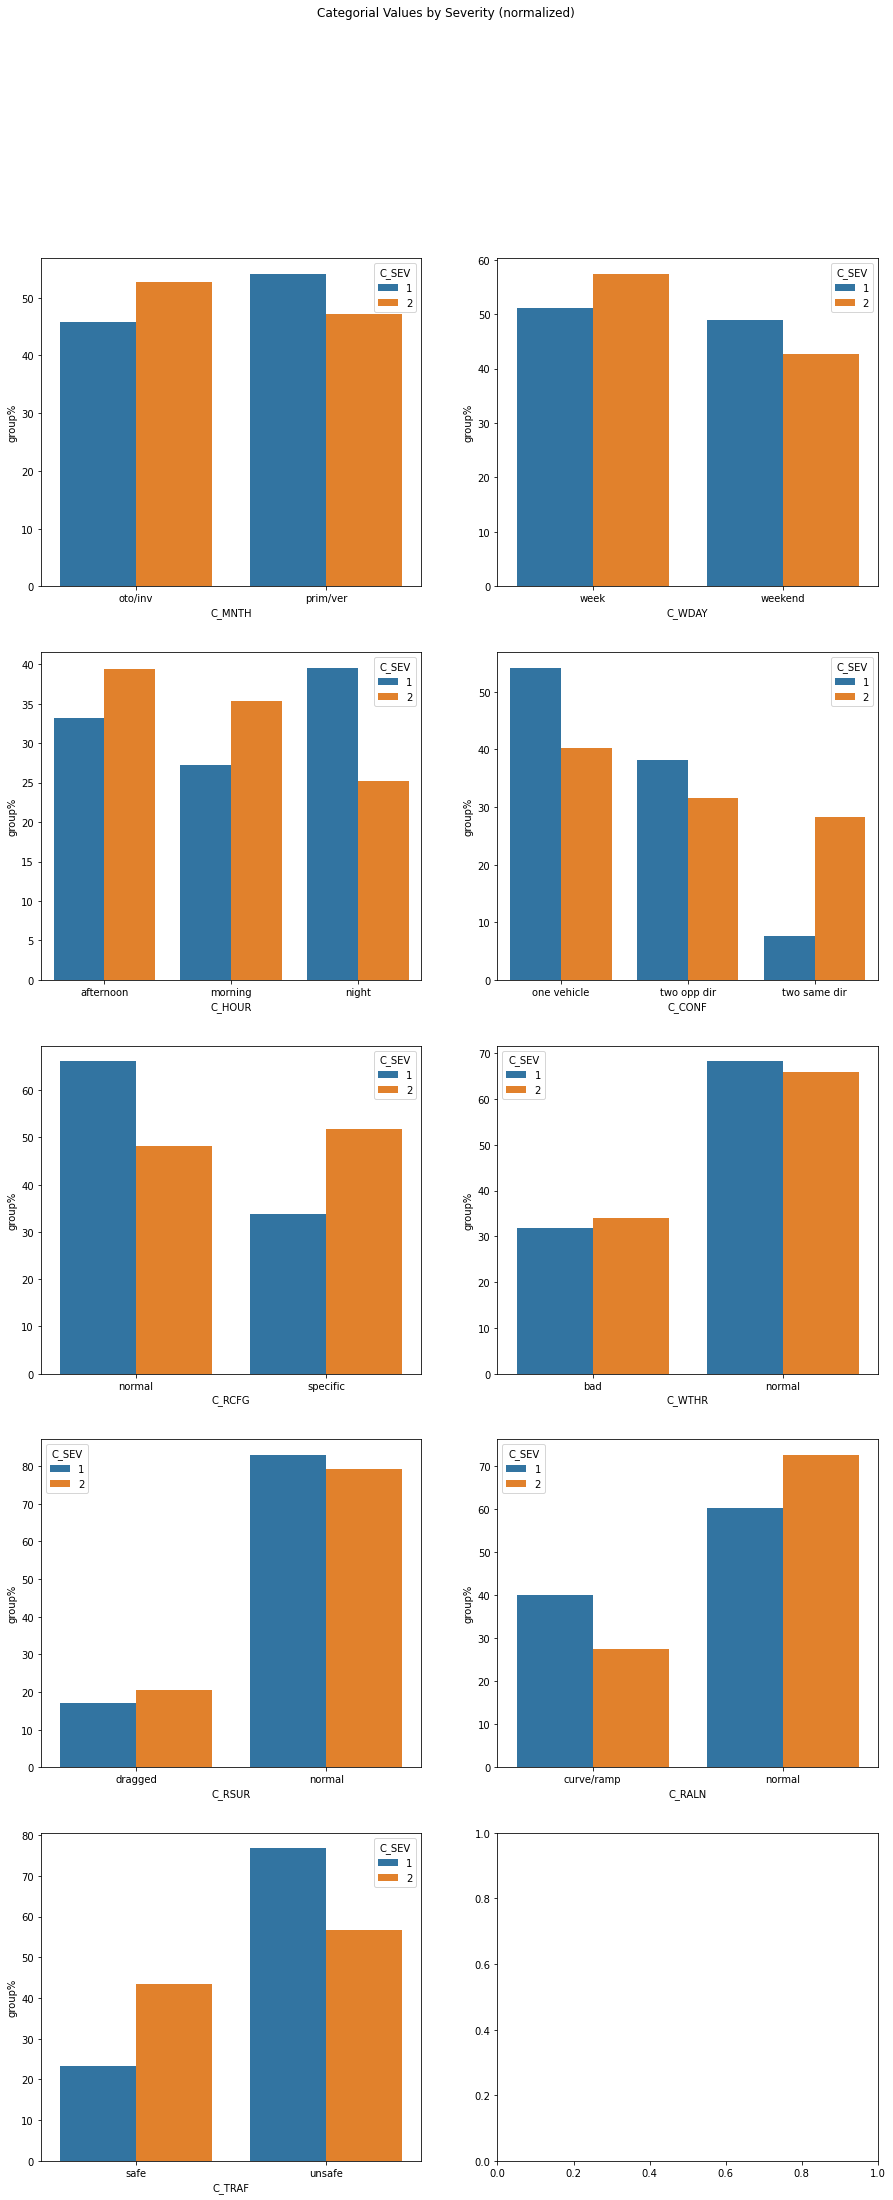

In [30]:
categorical = ['C_MNTH', 'C_WDAY', 'C_HOUR', 'C_CONF', 
               'C_RCFG', 'C_WTHR', 'C_RSUR', 'C_RALN', 
               'C_TRAF']

XY_train = X_train.copy()
XY_train['C_SEV'] = Y_train

fig, axes = plt.subplots(5, 2, figsize=(15, 35), sharey=False)
fig.suptitle('Categorial Values by Severity (normalized)')

i = 0
j = 0
for cat in categorical:
    temp = eda_tools.norm_category(df = XY_train, obj_val = 'C_SEV', cat_val = cat)
    sns.barplot(data = temp, x = cat, y = 'group%', hue = 'C_SEV', ax = axes[i,j]);
    if (j == 0): 
        j = 1
    else:
        j = 0
        i += 1

Como norma general debido al elevado uso de categorías en algunas variables, se va a evitar utilizar téncicas como OneHotEncoder de manera abusiva pues crearía demasidas variables.

**Label Encoder**

Se hará uso del LabelEncoder para las variables con solo dos categorías. Estas son: ```C_RCFG```, ```C_WTHR```, ```C_RSUR```, ```C_RALN``` y ```C_TRAF```. Al tener únicamente dos categorías, resulta interesante hacer uso de 0 y 1 para poder diferenciarlas. 

Ref: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

In [31]:
labelCat = ['C_RCFG', 'C_WTHR', 'C_RSUR', 'C_RALN', 'C_TRAF', 'C_MNTH', 'C_WDAY']
lb = preprocessing.LabelEncoder()

In [32]:
for cat in labelCat:
    X_train[cat] = lb.fit_transform(X_train[cat])
    X_test[cat] = lb.fit_transform(X_test[cat])
    print(lb.classes_)

['normal' 'specific']
['bad' 'normal']
['dragged' 'normal']
['curve/ramp' 'normal']
['safe' 'unsafe']
['oto/inv' 'prim/ver']
['week' 'weekend']


La variable objetivo hay que codificarla también:1 -> 0 y 2 -> 1

In [33]:
Y_train = lb.fit_transform(Y_train)
Y_test = lb.fit_transform(Y_test)
print(lb.classes_) # 1 Mortal y 2 No Mortal

[1 2]


**One Hot Encoder**

Finalmente, haremos uso del OneHotEncoder para la variable ```C_HOUR```. Esta solo tiene tres categorías lo que creará solo dos variables nuevas. 

Ref: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder

In [34]:
ohe = preprocessing.OneHotEncoder()

In [35]:
# Train
categories = ohe.fit_transform(X_train[['C_HOUR']]).toarray()
new_categories = ['C_HOUR_A', 'C_HOUR_M', 'C_HOUR_N']
position = 0
for nc in new_categories:
    accum = list()
    for enc in categories:
        accum.append(enc[position])
    X_train[nc] = accum
    position += 1

X_train = X_train.drop(['C_HOUR'], axis=1)

In [36]:
# Test
categories = ohe.fit_transform(X_test[['C_HOUR']]).toarray()
new_categories = ['C_HOUR_A', 'C_HOUR_M', 'C_HOUR_N']
position = 0
for nc in new_categories:
    accum = list()
    for enc in categories:
        accum.append(enc[position])
    X_test[nc] = accum
    position += 1

X_test = X_test.drop(['C_HOUR'], axis=1)

In [37]:
# Train
categories = ohe.fit_transform(X_train[['C_CONF']]).toarray()
new_categories = ['C_CONF_O', 'C_CONF_TO', 'C_CONF_TS']
position = 0
for nc in new_categories:
    accum = list()
    for enc in categories:
        accum.append(enc[position])
    X_train[nc] = accum
    position += 1

X_train = X_train.drop(['C_CONF'], axis=1)

In [38]:
# Test
categories = ohe.fit_transform(X_test[['C_CONF']]).toarray()
new_categories = ['C_CONF_O', 'C_CONF_TO', 'C_CONF_TS']
position = 0
for nc in new_categories:
    accum = list()
    for enc in categories:
        accum.append(enc[position])
    X_test[nc] = accum
    position += 1

X_test = X_test.drop(['C_CONF'], axis=1)

## 3.4 Balanceo
En el EDA pudimos apreciar como había un importante desequilibrio en la variable objetivo, existiendo un 98% y 2% de accidentes no mortales y mortales respectivamente. 

In [39]:
X_train_sev = X_train
X_train['C_SEV'] = Y_train
eda_tools.classes_overview(df = X_train_sev, obj_val = 'C_SEV')

,index,percentaje,C_SEV
0,1,98.059531,1404540
1,0,1.940469,27794


Realizamos un undersampling de la clase mayoritaria para equilibrar la muestra. 

- Primero separaremos por clases:

In [40]:
# Dividimos la clases
sev01_df = X_train_sev[X_train_sev['C_SEV'] == 0]
sev02_df = X_train_sev[X_train_sev['C_SEV'] == 1]

- Ahora equilibramos 50-50. Se realiza esto para equilibrar la muestra de train y permtir al modelo aprender en la misma proporcion ambas clases. De tal forma que evitemos un sesgo a la hora de predecir en el futuro.

In [41]:
# Tamaño a muestrear
sample_size = int(sev01_df.shape[0] * (1.00))

# Realizamos una muestra del sev02_df
sev02_sam_df = resample(sev02_df, replace=True, n_samples = sample_size, random_state=0)

# Juntamos y creamos la versión a utilizar
X_train_sev = pd.concat([sev01_df, sev02_sam_df])
X_train_sev['C_SEV'].value_counts()

0    27794
1    27794
Name: C_SEV, dtype: int64

Observamos como se ha reducido considerablemente la muestra de accidentes no mortales, y hemos podido equilibrar en cierto grado el dataset. 

In [42]:
Y_train = X_train_sev['C_SEV'].copy()
X_train = X_train_sev.drop(['C_SEV'], axis = 1)

## 3.5 Selección de variables

### 3.5.1 Correlaciones

<AxesSubplot:>

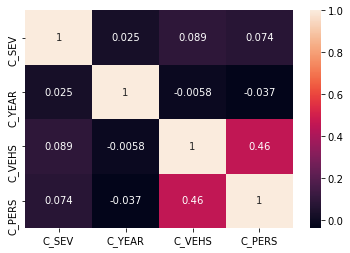

In [43]:
XY_train = X_train.copy()
XY_train['C_SEV'] = Y_train
sns.heatmap(XY_train[['C_SEV', 'C_YEAR', 'C_VEHS', 'C_PERS']].corr(), annot = True)

Analizamos las correlaciones de las variables continuas del modelo. Observamos como no existe una fuerte correlación con la variable objetivo, si bien las variables ```C_VEHS``` y ```C_PERS``` muestran un correlación a destacar. Esta es normal teniendo en cuenta que el número de vehículos involucrados tienen una relación con las personas involucradas al ser estas usuarios de estos vehículos. Veremos si es necesario eliminar alguna, aunque su correlación tampoco es muy elevada como para ser eliminadas.

Analizamos en detalle los valores de las variables numéricas

In [44]:
train_numeric = XY_train[['C_SEV', 'C_YEAR', 'C_VEHS', 'C_PERS']].copy()
train_numeric.describe()

,C_SEV,C_YEAR,C_VEHS,C_PERS
count,55588.000000,55588.000000,55588.000000,55588.000000
mean,0.500000,2006.024070,1.725678,2.761046
std,0.500004,4.549517,0.958940,2.368490
min,0.000000,1999.000000,1.000000,1.000000
25%,0.000000,2002.000000,1.000000,1.000000
50%,0.500000,2006.000000,2.000000,2.000000
75%,1.000000,2010.000000,2.000000,3.000000
max,1.000000,2014.000000,77.000000,92.000000


<AxesSubplot:xlabel='C_VEHS', ylabel='C_SEV'>

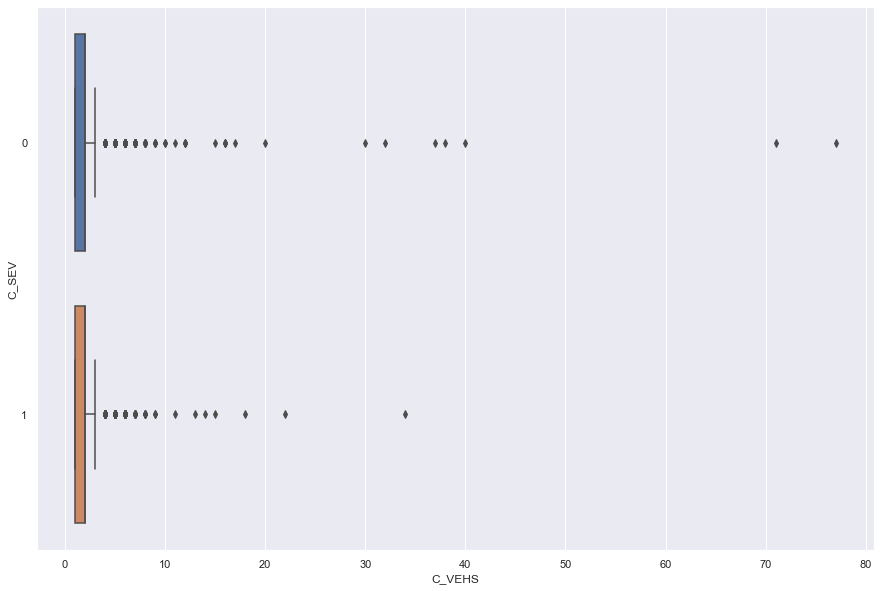

In [45]:
sns.set(rc={'figure.figsize':(15,10)})
sns.boxplot(data=train_numeric[['C_VEHS', 'C_SEV']], orient="h", x='C_VEHS', y='C_SEV')

La mayoría de accidentes ocurren son entre pocos vehículos 2 o 3, sin embargo existen accidentes con una multitud considerable. Destacamos dos accidentes mortales con un total de entre 70 y 80 vehículos. 

<AxesSubplot:xlabel='C_PERS', ylabel='C_SEV'>

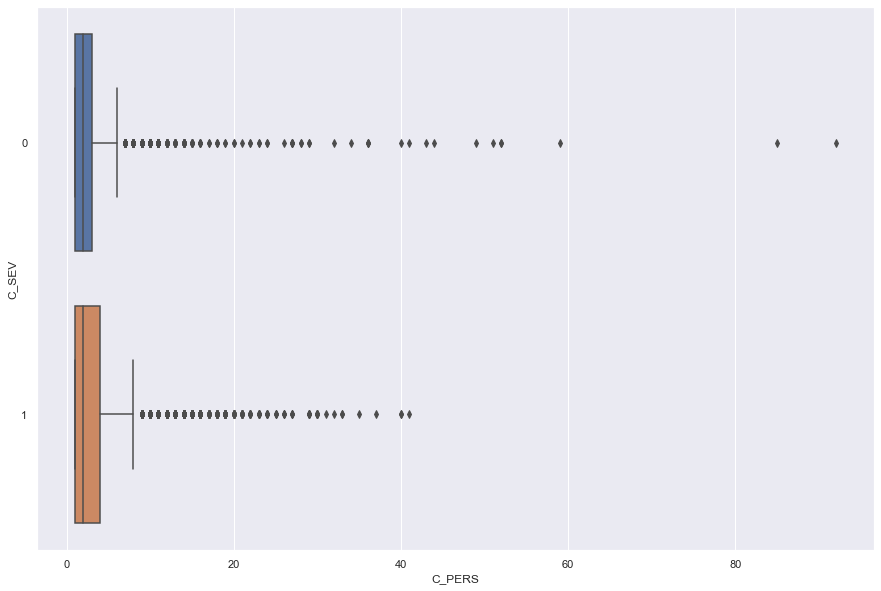

In [46]:
sns.set(rc={'figure.figsize':(15,10)})
sns.boxplot(data=train_numeric[['C_PERS', 'C_SEV']], orient="h", x='C_PERS', y='C_SEV')

Observamos algo similar, existen accidentes con menos de 10 personas involucradas, sin embargo también tenemos accidentes con multitud de personas.

Estos valores no se eliminan pues no son extraños, es razonable y normal que un accidente con tantos involucrados tenga fallecidos.

### 3.5.2 Regresión de Lasso
A continuación procedemos a realizar una regresión de Lasso con el objetivo de valorar que variables del modelo son mayormente significativas e importantes para el mismo. De esta forma reducimos las variables y simplificamos el modelo.

Previamente eliminamos, la variable año, la razón es que esta variable no aporta información de cara a una predicción pues los accidentes que ocurran en el futuro no poseeran datos interesantes en esta variable. 

In [47]:
# Quitamos la variable año pues no aporta información al modelo y no está escalada.
X_train = X_train.drop(['C_YEAR'], axis = 1)
X_test = X_test.drop(['C_YEAR'], axis = 1)

In [48]:
# Lasso con treshold 0.002 (mejor treshold de cara a los modelos posteriores)
sel_lasso = SelectFromModel(LogisticRegression(C=1, penalty='l1', 
                                          solver='liblinear'), threshold = 0.002)
sel_lasso.fit(X_train, Y_train)

SelectFromModel(estimator=LogisticRegression(C=1, penalty='l1',
                                             solver='liblinear'),
                threshold=0.002)

In [49]:
sel_lasso.get_support()
selected_feat_lasso = X_train.columns[sel_lasso.get_support()]
selected_feat_lasso

Index(['C_MNTH', 'C_WDAY', 'C_VEHS', 'C_RCFG', 'C_WTHR', 'C_RSUR', 'C_RALN',
       'C_TRAF', 'C_PERS', 'C_HOUR_A', 'C_HOUR_M', 'C_HOUR_N', 'C_CONF_O',
       'C_CONF_TO', 'C_CONF_TS'],
      dtype='object')

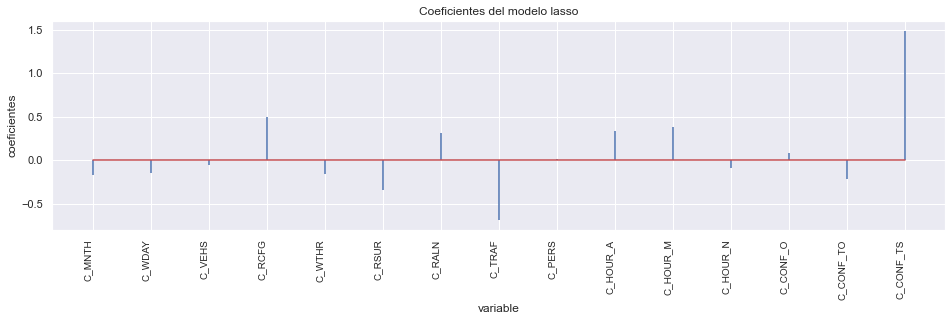

In [50]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes_lasso = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': sel_lasso.estimator_.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(16, 3.84))
ax.stem(df_coeficientes_lasso.predictor, df_coeficientes_lasso.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo lasso');

**A POSTERIORI**: Se han probado varios tresholds entre 0.001 y 0.1, el valor 0.002 es el que mejor resultados ha dado de cara a modelo que se verá a continuación.

In [51]:
# Descomentar solo si hacemos uso de Lasso
X_train = X_train[selected_feat_lasso]
X_test = X_test[selected_feat_lasso]

## 3.6 Modelo final

Finalmente, ya tenemos dos conjuntos procesados de train y test que podemos utilizar para realizar los modelos:

### 3.6.1 Train

In [52]:
X_train.head()

,C_MNTH,C_WDAY,C_VEHS,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,C_PERS,C_HOUR_A,C_HOUR_M,C_HOUR_N,C_CONF_O,C_CONF_TO,C_CONF_TS
1592462,0,1,2.0,0,1,1,1,1,4.0,1.0,0.0,0.0,0.0,1.0,0.0
895090,1,0,2.0,0,0,1,0,1,2.0,0.0,0.0,1.0,0.0,1.0,0.0
527589,1,0,2.0,1,1,1,1,0,3.0,0.0,0.0,1.0,0.0,1.0,0.0
210194,1,1,1.0,0,1,1,1,1,2.0,0.0,1.0,0.0,1.0,0.0,0.0
540583,1,1,1.0,0,1,1,0,1,5.0,0.0,0.0,1.0,1.0,0.0,0.0


In [53]:
# Guardado de train
XY_train = X_train.copy()
XY_train['C_SEV'] = Y_train

# Revisar nombres antes de guardar (CUIDADO: Sobreescritura)
# Crear nueva carpeta <model_x> si es nuevo
XY_train.to_csv("../data/csev/fulltrainCSEVscal.csv", index=False)

### 3.6.2 Test


In [54]:
X_test.head()

,C_MNTH,C_WDAY,C_VEHS,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,C_PERS,C_HOUR_A,C_HOUR_M,C_HOUR_N,C_CONF_O,C_CONF_TO,C_CONF_TS
1573164,0,1,2.0,1,0,1,1,0,4.0,0.0,1.0,0.0,0.0,1.0,0.0
253000,0,0,4.0,0,1,1,1,1,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1419439,1,1,1.0,0,1,1,0,1,1.0,0.0,0.0,1.0,1.0,0.0,0.0
271512,0,0,1.0,1,1,1,1,0,7.0,1.0,0.0,0.0,1.0,0.0,0.0
814279,1,1,1.0,1,0,1,1,1,2.0,0.0,0.0,1.0,1.0,0.0,0.0


In [55]:
# Guardado de test
XY_test = X_test.copy()
XY_test['C_SEV'] = Y_test

# Revisar nombres antes de guardar (CUIDADO: Sobreescritura)
# Crear nueva carpeta <model_x> si es nuevo
XY_test.to_csv("../data/csev/fulltestCSEVscal.csv", index=False)

---

<div style='text-align:center'>Elaborado por Álvaro Serrano del Rincón (<i>a.serranodelrincon@cunef.edu</i>)</div> 
<div style='text-align:center'>y Carlos Viñals Guitart (<i>carlos.vinals@cunef.edu</i>)</div> 